## 2. MSTLによる時系列分解と多重周期性の構造把握

**概要:**
- 本ノートブックでは、MSTL（Multiple Seasonal-Trend decomposition using LOESS）を用いて、電力の発電量および需要量の時系列データが持つ多重周期性（日次、週次、年次）を分解し、その構造を可視化・分析する。

### 2-1. 分析の準備

#### 2-1-1. ライブラリのインポートとデータ読み込み

In [1]:
# ライブラリのインポート
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL, MSTL
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from src.data_utils import load_timeseries_data

import warnings
# 警告を非表示にする
warnings.filterwarnings("ignore")

# 日本語フォントの設定（文字化け対策）windows or mac
plt.rcParams['font.family'] = 'Meiryo' # Windowsの場合
# plt.rcParams['font.family'] = 'Hiragino Sans' # Macの場合

In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)
df.head()

series_gen = df['solar_gen_mw'].copy() # 発電
series_demand = df['e_demand_mw'].copy() # 消費

print("データ準備完了。分析対象期間: ", series_gen.index.min(), " ~ ", series_gen.index.max())

データ準備完了。分析対象期間:  2023-01-01 00:00:00  ~  2025-03-31 23:30:00


### 2-2. 主要周期（日次・週次）によるMSTL分解

#### 2-2-1. 分解の準備と実行関数の定義

In [3]:
# MSTL 周期決定
# 分析対象とする周期を定義
# 日周期: 48 (30分 * 48コマ/日)
# 週周期: 336 (48コマ * 7日/週)
# 年周期 (48*365) はデータ期間が短い、または計算負荷が高いため、今回は省略する。
PERIODS = [48, 336]

print(f"MSTL分析準備完了。周期: {PERIODS}")

MSTL分析準備完了。周期: [48, 336]


In [4]:
def perform_mstl_decomposition(series, series_name, periods):
    """MSTL分解を実行し、結果をmatplotlibで可視化する関数"""

    print(f"\n==================================================")
    print(f"  MSTL分解: {series_name} (周期: {periods})")
    print(f"==================================================")
    
    # MSTL分解を実行
    mstl = MSTL(
        series.dropna(), 
        periods=periods, 
        stl_kwargs={"robust": True, "seasonal_deg":0} 
    )
    res = mstl.fit()

    # --- matplotlibで可視化 ---
    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
    fig.suptitle(f"{series_name} のMSTL分解結果 (日周期と週周期)", fontsize=16)

    # 観測値
    axes[0].plot(res.observed)
    axes[0].set_ylabel("Observed")

    # トレンド
    axes[1].plot(res.trend)
    axes[1].set_ylabel("Trend")

    # 季節性1 (日周期)
    axes[2].plot(res.seasonal.iloc[:, 0])
    axes[2].set_ylabel(f"Seasonal (P={periods[0]})")

    # 季節性2 (週周期)
    axes[3].plot(res.seasonal.iloc[:, 1])
    axes[3].set_ylabel(f"Seasonal (P={periods[1]})")

    # 残差
    axes[4].plot(res.resid, marker='.', linestyle='None', markersize=2)
    axes[4].set_ylabel("Residual")
    axes[4].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # suptitleとの重なりを調整
    plt.show()

#### 2-2-2. 発電量（solar_gen_mw）の分解結果


  MSTL分解: 発電 (solar_gen_mw) (周期: [48, 336])


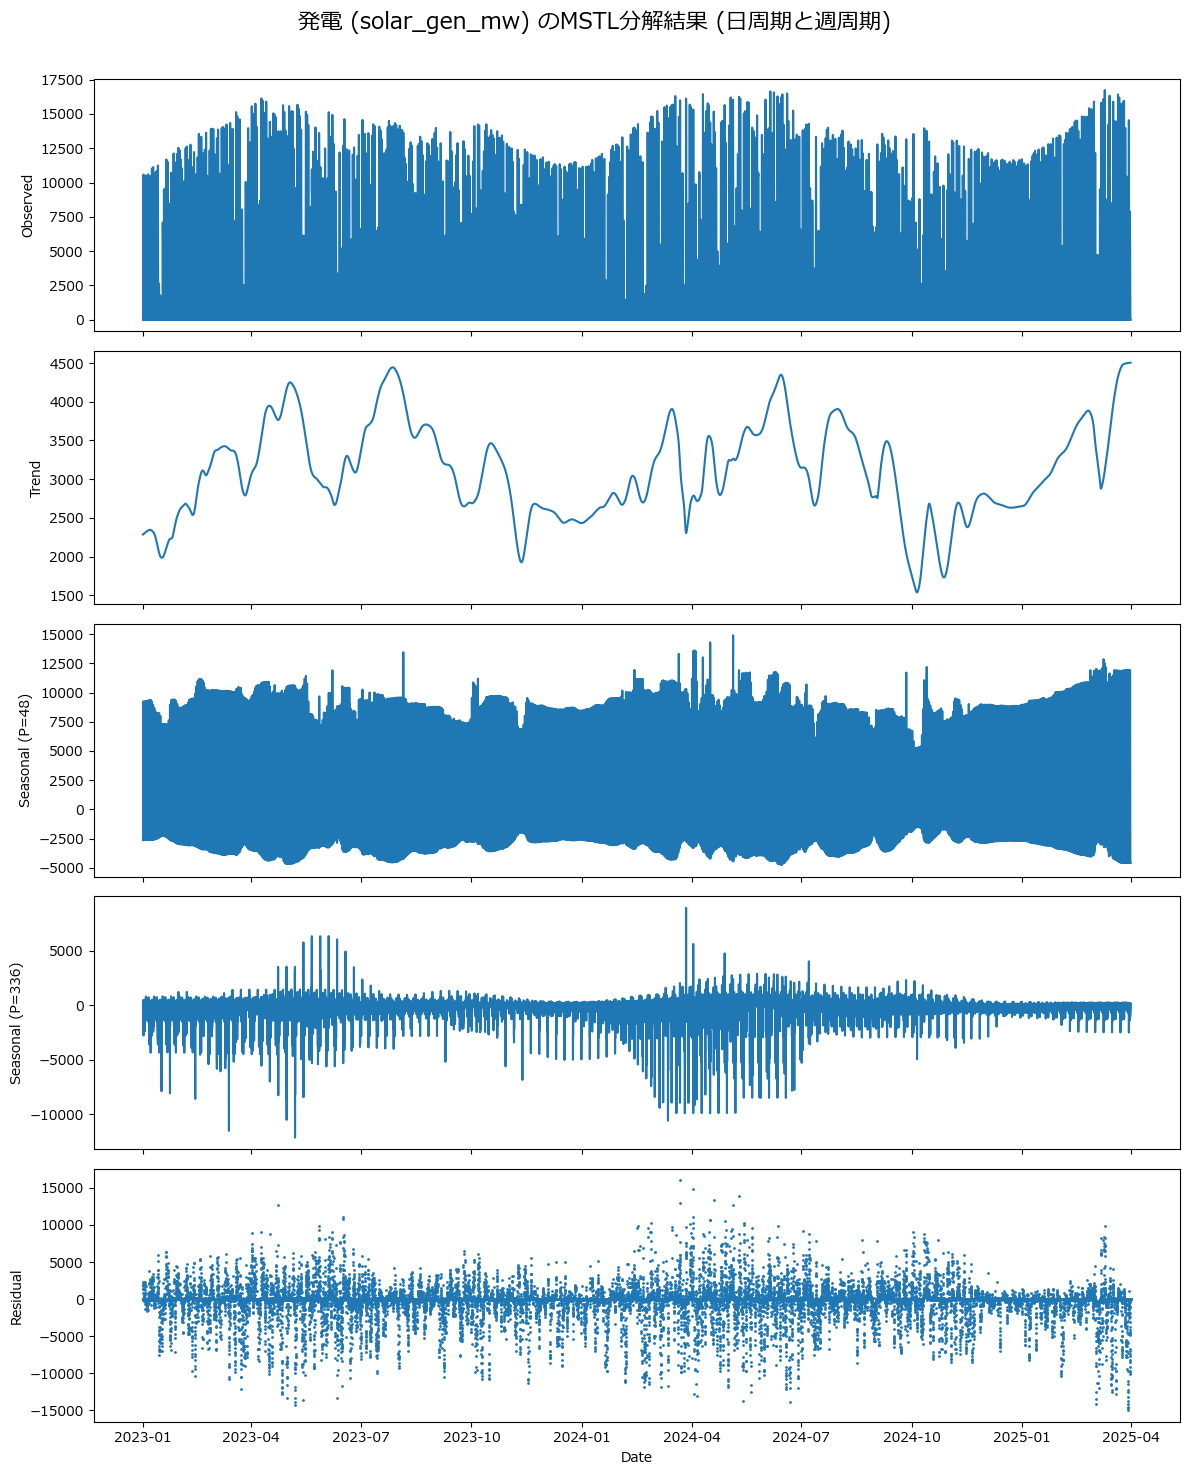

In [5]:
perform_mstl_decomposition(series_gen, "発電 (solar_gen_mw)", periods=PERIODS)

#### 2-2-2. 需要量（ e_demand_mw）の分解結果


  MSTL分解: 消費 (e_demand_mw) (周期: [48, 336])


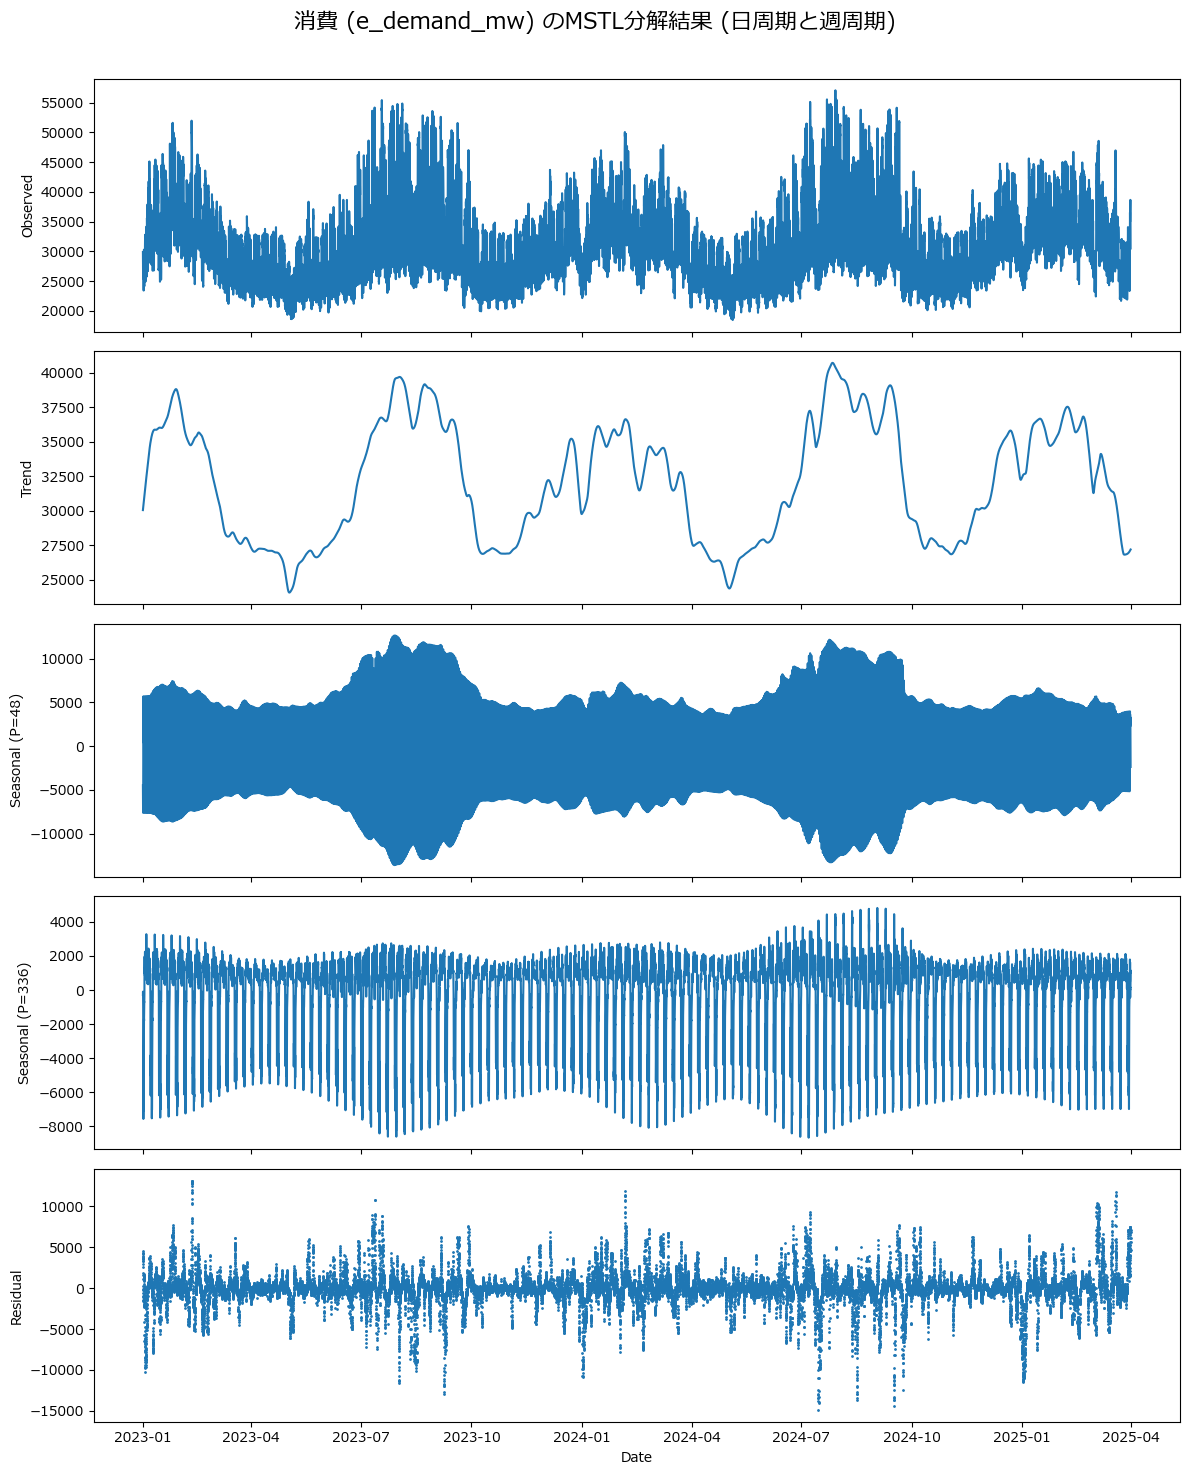

In [6]:
perform_mstl_decomposition(series_demand, "消費 (e_demand_mw)", periods=PERIODS)

### 2-3. 年周期を追加したMSTL分解による長期変動の分析
- 週次以上の長期周期の影響を見るため、年周期(17529コマ)をMSTLに加えて分解する。

In [7]:
# 年周期を加えた周期リストを定義
PERIODS_YEAR = [48, 336, 17520] # 日、週、年

print(f"MSTL分析（年周期含む）準備完了。周期: {PERIODS_YEAR}")

MSTL分析（年周期含む）準備完了。周期: [48, 336, 17520]


In [8]:
def perform_mstl_decomposition_3_periods(series, series_name, periods):
    """3つの周期でMSTL分解を実行し、結果をmatplotlibで可視化する関数"""

    print(f"\n==================================================")
    print(f"  MSTL分解: {series_name} (周期: {periods})")
    print(f"==================================================")
    
    # MSTL分解を実行
    mstl = MSTL(
        series.dropna(), 
        periods=periods, 
        stl_kwargs={"robust": True, "seasonal_deg": 0}
    )
    res = mstl.fit()

    # --- matplotlibで可視化 (サブプロットを6つに増やす) ---
    fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)
    fig.suptitle(f"{series_name} のMSTL分解結果 (日・週・年周期)", fontsize=16)

    # 観測値
    axes[0].plot(res.observed)
    axes[0].set_ylabel("Observed")

    # トレンド
    axes[1].plot(res.trend)
    axes[1].set_ylabel("Trend")

    # 季節性1 (日周期)
    axes[2].plot(res.seasonal.iloc[:, 0])
    axes[2].set_ylabel(f"Seasonal (P={periods[0]})")

    # 季節性2 (週周期)
    axes[3].plot(res.seasonal.iloc[:, 1])
    axes[3].set_ylabel(f"Seasonal (P={periods[1]})")

    # 季節性3 (年周期)
    axes[4].plot(res.seasonal.iloc[:, 2])
    axes[4].set_ylabel(f"Seasonal (P={periods[2]})")

    # 残差
    axes[5].plot(res.resid, marker='.', linestyle='None', markersize=2)
    axes[5].set_ylabel("Residual")
    axes[5].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # suptitleとの重なりを調整
    plt.show()

#### 2-3-2. 発電量（solar_gen_mw）の分解結果（年周期含む）


  MSTL分解: 発電 (solar_gen_mw) (周期: [48, 336, 17520])


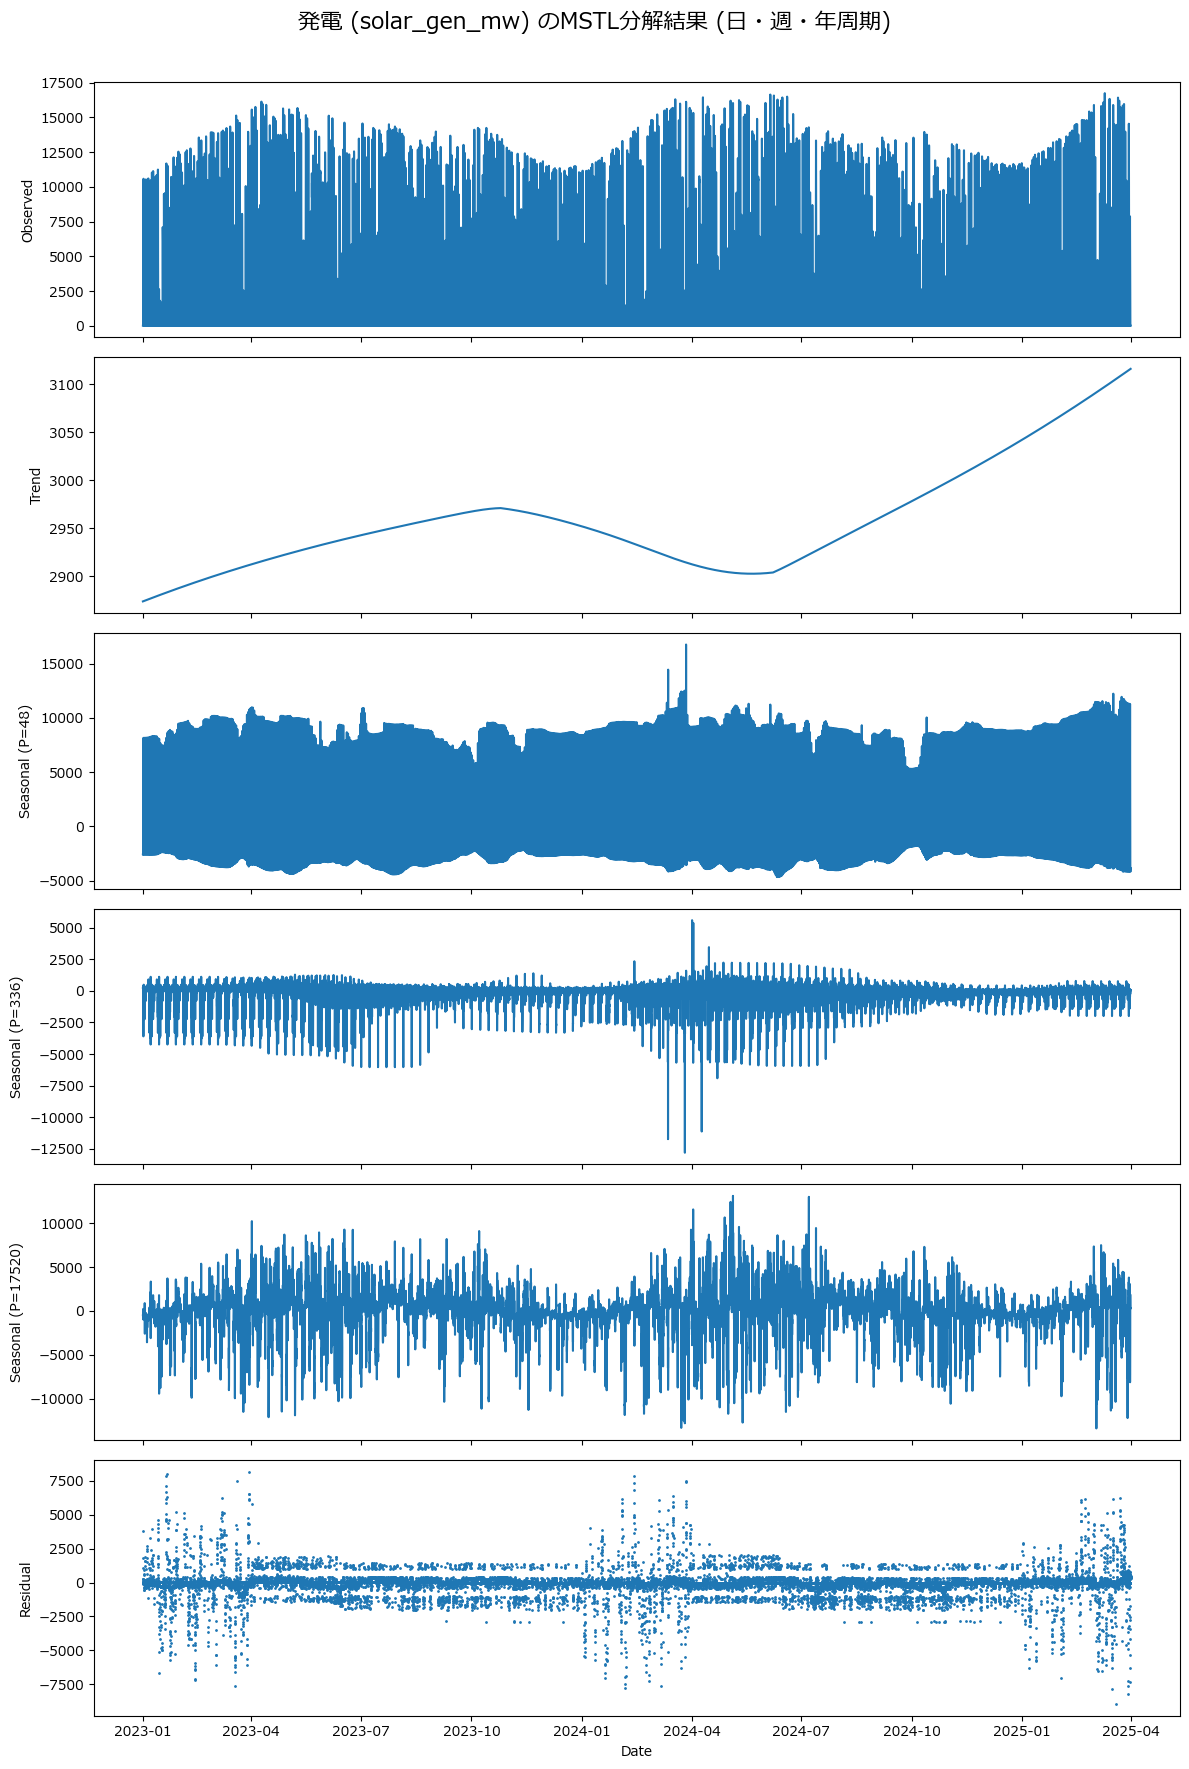

In [9]:
# 発電量に対して年周期を含むMSTL分解を実行  実行時間128mなど注意
perform_mstl_decomposition_3_periods(series_gen, "発電 (solar_gen_mw)", periods=PERIODS_YEAR)

#### 2-3-3. 需要量（e_demand_mw）の分解結果（年周期含む）


  MSTL分解: 消費 (e_demand_mw) (周期: [48, 336, 17520])


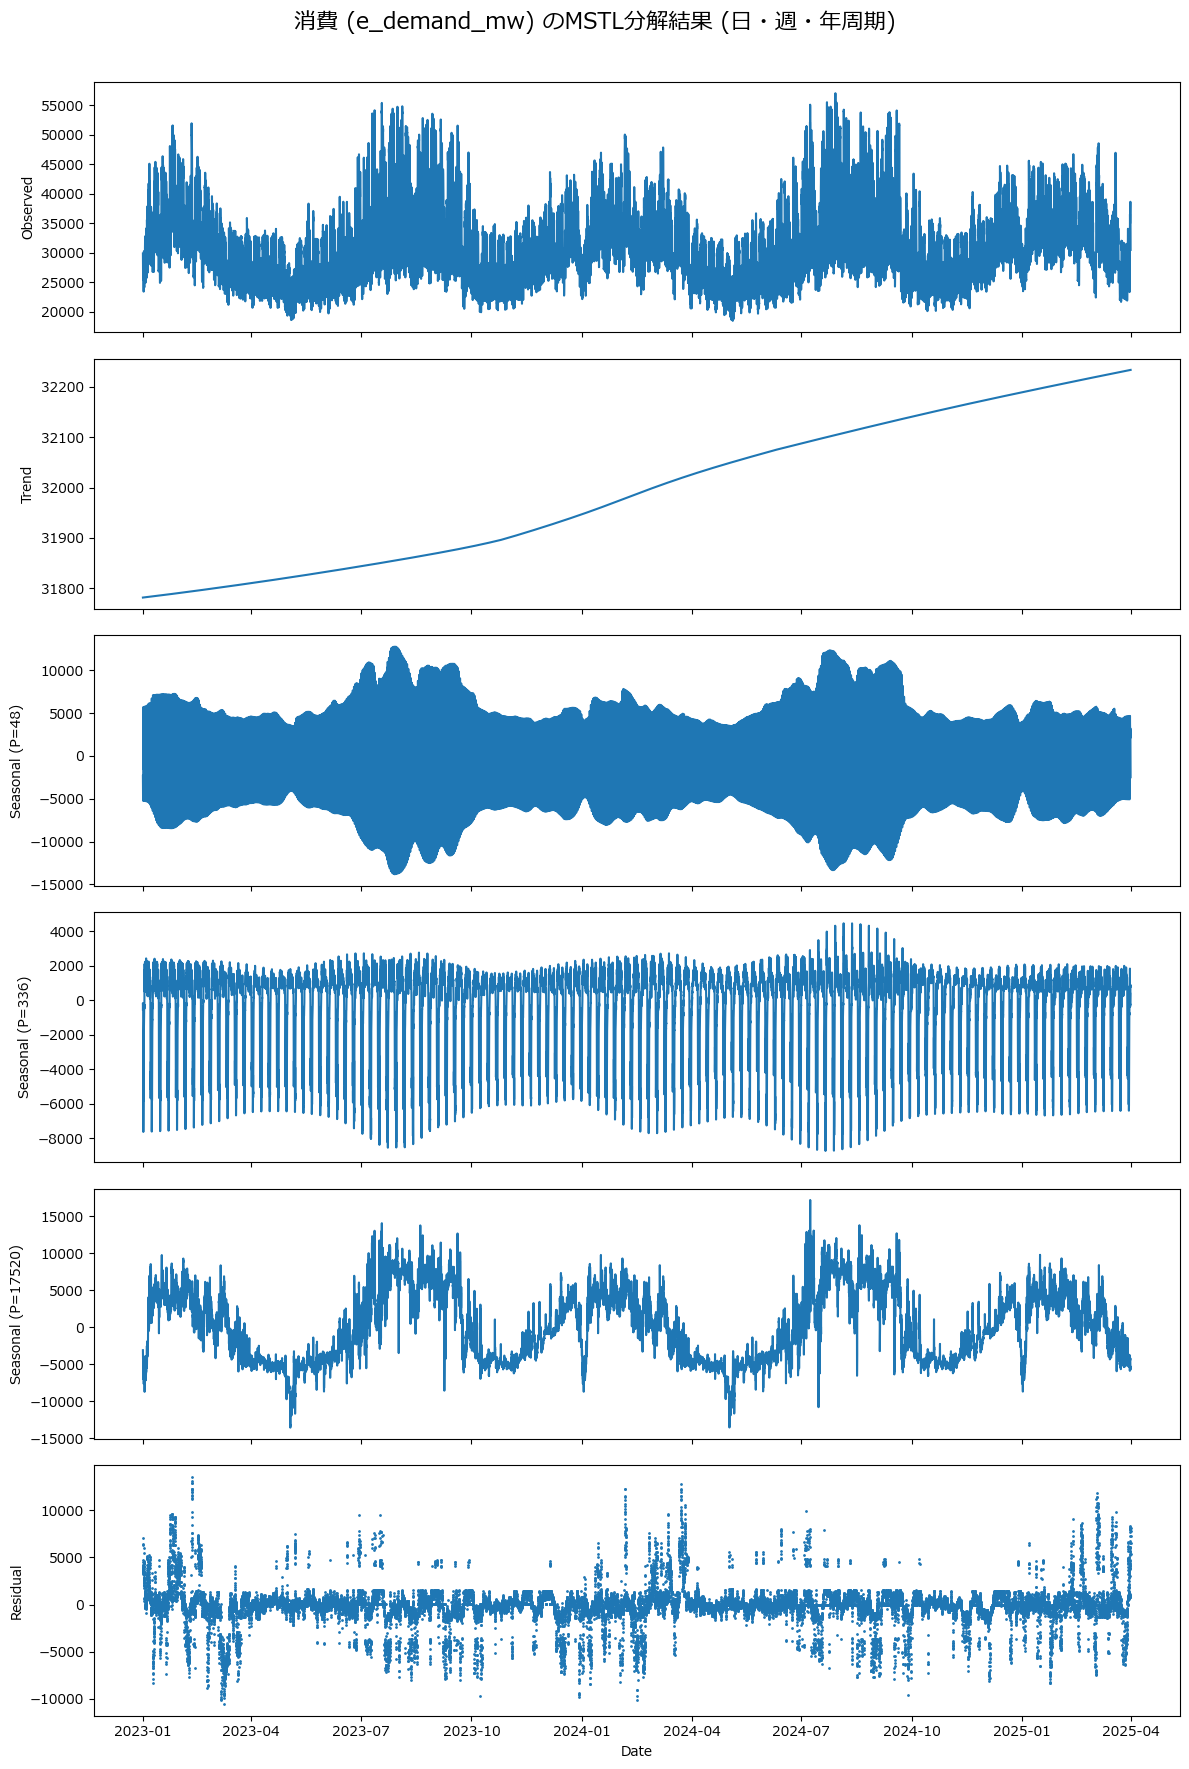

In [10]:
# 需要量に対して年周期を含むMSTL分解を実行
perform_mstl_decomposition_3_periods(series_demand, "消費 (e_demand_mw)", periods=PERIODS_YEAR)

### 2-4. 結論と次工程への移行

1. 多重周期性の確認とトレンドの分離

* 発電量・需要量ともに、日周期（48コマ）および週周期（336コマ）に加えて、年周期（17,520コマ）が存在することが示唆された。(発電は太陽の射角、消費は気温からの冷暖房需要や人間の活動からも裏付けられる。)

* 年周期を追加することで、長期的な季節変動がトレンド成分から分離され、トレンドラインが単純化されたことは、分解の有効性を示唆する。


2. MSTLの限界と課題

* MSTLによる季節成分の抽出は、複数の周期が複雑に絡み合うため、各成分のパターンを直感的に解釈することが困難である。

* また、太陽光発電のように夜間に値がゼロとなるデータに対しては、STL/MSTLのような線形的な手法では残差に大きな偏りが残る可能性があり、モデル化の難易度が高いことが示された。


3. 次工程への分析方針の転換

* 複雑な多重周期パターンをモデル構築に活用するため、次工程では**時間軸での集計（タイムベース・アグリゲーション）**に分析方針を転換する。具体的には、時間帯別、曜日別などの平均パターンを可視化し、時系列の変動要因をより直感的かつ定量的に把握することを目指す。